In [1]:
import os
import time
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

Running Scanpy 1.6.0, on 2021-06-12 00:09.


In [2]:
adata = sc.read_h5ad('/media/bgi/zoubin/single_cell/batch_correction/data/HCA.h5ad')
adata.obs['batch'] = adata.obs['tissue']

celltypes = adata.obs.celltype.tolist()
consider_celltypes = ['CLP', 'CMP', 'DC', 'Erythrocytes', 'Fibroblasts', 'GMP', 'HSC', 'Macrophages', 
                      'Megakaryocytes', 'Memory.B.cells', 'MEP',
                      'Mono', 'MPP', 'Myeloid.progenitor', 'naive.B.cells', 'PBMC_cd4mem', 'PBMC_cd4naive', 'PBMC_cd8mem',
                      'PBMC_cd8naive', 'PBMC_nk', 'PBMC_treg', 'Plasma.cells']
celltypes=['DC' if i.startswith('DC') else i for i in celltypes]
celltypes=['Mono' if i.startswith('Mono') else i for i in celltypes]
celltypes=['remove' if i not in consider_celltypes else i for i in celltypes]
adata.obs['celltype'] = celltypes
adata = adata[adata.obs.celltype != 'remove']

adata0 = adata[adata.obs.batch=='blood']
adata1 = adata[adata.obs.batch=='marrow']
del adata

In [3]:
#adata0 processed
sc.pp.normalize_per_cell(adata0, counts_per_cell_after=1e4)
sc.pp.log1p(adata0)
sc.pp.scale(adata0)
sc.tl.pca(adata0, svd_solver='arpack')

#adata1 processed
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
sc.tl.pca(adata1, svd_solver='arpack')

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50


MemoryError: Unable to allocate 23.4 GiB for an array with shape (252830, 24823) and data type float32

In [ ]:
#生成MMD算法输入的文件，2个只包含表达矩阵的csv
data0 = pd.DataFrame(adata0.obsm['X_pca'])
data1 = pd.DataFrame(adata1.obsm['X_pca'])

data0.to_csv('Figure6_HCA_0.csv',index=None,header=None)
data1.to_csv('Figure6_HCA_1.csv',index=None,header=None)

In [2]:
!python train.py

Epoch 1, loss: 0.236, counter: 0
Learning rate = 0.0000100
Epoch 2, loss: 0.236, counter: 1
Learning rate = 0.0000100
Epoch 3, loss: 0.236, counter: 2
Learning rate = 0.0000100
Epoch 4, loss: 0.236, counter: 3
Learning rate = 0.0000100
Epoch 5, loss: 0.236, counter: 0
Learning rate = 0.0000100
Epoch 6, loss: 0.236, counter: 1
Learning rate = 0.0000100
Epoch 7, loss: 0.236, counter: 2
Learning rate = 0.0000100
Epoch 8, loss: 0.236, counter: 0
Learning rate = 0.0000100
Epoch 9, loss: 0.236, counter: 1
Learning rate = 0.0000010
Epoch 10, loss: 0.236, counter: 2
Learning rate = 0.0000010
Epoch 11, loss: 0.236, counter: 3
Learning rate = 0.0000010
Epoch 12, loss: 0.236, counter: 4
Learning rate = 0.0000010
Epoch 13, loss: 0.236, counter: 5
Learning rate = 0.0000010
Finished training
Figure(800x800)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists wi

In [2]:
data0 = np.load("sample1.csv.npy")
data1 = np.load("calibrated_sample2.csv.npy")

In [3]:
adata = sc.read_h5ad('/media/bgi/zoubin/single_cell/batch_correction/data/HCA.h5ad')
adata.obs['batch'] = adata.obs['tissue']

celltypes = adata.obs.celltype.tolist()
consider_celltypes = ['CLP', 'CMP', 'DC', 'Erythrocytes', 'Fibroblasts', 'GMP', 'HSC', 'Macrophages', 
                      'Megakaryocytes', 'Memory.B.cells', 'MEP',
                      'Mono', 'MPP', 'Myeloid.progenitor', 'naive.B.cells', 'PBMC_cd4mem', 'PBMC_cd4naive', 'PBMC_cd8mem',
                      'PBMC_cd8naive', 'PBMC_nk', 'PBMC_treg', 'Plasma.cells']
celltypes=['DC' if i.startswith('DC') else i for i in celltypes]
celltypes=['Mono' if i.startswith('Mono') else i for i in celltypes]
celltypes=['remove' if i not in consider_celltypes else i for i in celltypes]
adata.obs['celltype'] = celltypes
adata = adata[adata.obs.celltype != 'remove']

adata0 = adata[adata.obs.batch=='blood']
adata1 = adata[adata.obs.batch=='marrow']

adata0.obsm['X_pca'] = data0
adata1.obsm['X_pca'] = data1

In [4]:
adata_MMD = adata0.concatenate(adata1,index_unique=None,batch_categories=['blood','marrow'])

In [5]:
del adata0, adata1

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:13:43)
... storing 'celltype' as categorical
... storing 'library_id' as categorical
... storing 'sample_id' as categorical
... storing 'tissue' as categorical


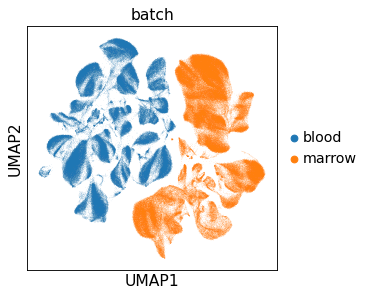

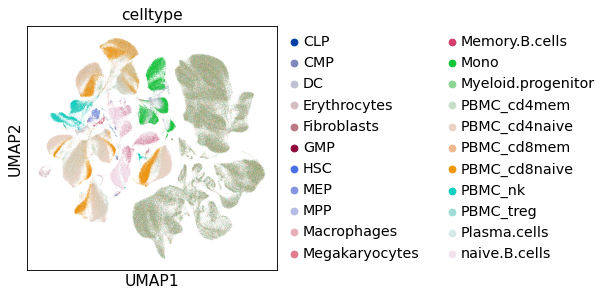

In [6]:
#plot result
sc.pp.neighbors(adata_MMD)
sc.tl.umap(adata_MMD)

sc.pl.umap(adata_MMD,color=['batch'],save='_figure6_MMD_batch.pdf')
sc.pl.umap(adata_MMD,color=['celltype'],save='_figure6_MMD_celltype.pdf')

In [7]:
adata_MMD.write('adata_MMD.h5ad')

In [14]:
adata_MMD.obs.batch

MantonCB1_HiSeq_1-AAACCTGAGGAGTTGC-1    0
MantonCB1_HiSeq_1-AAACCTGCACAGACAG-1    0
MantonCB1_HiSeq_1-AAACCTGCACAGATTC-1    0
MantonCB1_HiSeq_1-AAACCTGCACCCAGTG-1    0
MantonCB1_HiSeq_1-AAACCTGCACTGTGTA-1    0
                                       ..
MantonBM8_HiSeq_8-TTTGTCAGTATCAGTC-1    1
MantonBM8_HiSeq_8-TTTGTCAGTCAACATC-1    1
MantonBM8_HiSeq_8-TTTGTCATCATTTGGG-1    1
MantonBM8_HiSeq_8-TTTGTCATCCTCAACC-1    1
MantonBM8_HiSeq_8-TTTGTCATCTTGAGAC-1    1
Name: batch, Length: 528014, dtype: category
Categories (2, object): ['0', '1']

In [ ]:
from math import log
from sklearn.metrics import silhouette_score

def shannon_entropy (x, b_vec, N_b):
    
    tabled_values = b_vec[x > 0].value_counts()/ len(b_vec[x >0]) #class 'pandas.core.series.Series'

    tabled_val = tabled_values.tolist() 
    
    entropy = 0.0
    for element in tabled_val:
        if element != 0:
            entropy += element * log(element)
            
    entropy /= log(N_b)

    return(-entropy) #the entropy formula is the -sum, this is why we include the minus sign

def compute_entropy(adata, output_entropy=None, batch_key='batch', celltype_key='celltype'):
    print("Calculating entropy ...")
    kwargs = {}
    #batch vector(batch id of each cell)
    kwargs['batch_vector'] = adata.obs[batch_key]
    #modify index of batch vector so it coincides with matrix's index
    kwargs['batch_vector'].index = range(0,len(kwargs['batch_vector']))
    #number of batches
    kwargs['N_batches'] = len(adata.obs[batch_key].astype('category').cat.categories)

    #cell_type vector( betch id of each cell)
    kwargs['cell_type_vector'] = adata.obs[celltype_key]
    #modify index of cell_type vector so it coincides with matrix's index
    kwargs['cell_type_vector'].index = range(0,len(kwargs['cell_type_vector']))
    #number of cell_types
    kwargs['N_cell_types'] = len(adata.obs[celltype_key].astype('category').cat.categories)    

    try:
        knn_graph = adata.uns['neighbors']
        print('use exist neighbors')
    except KeyError:
        #compute neighbors
        print('compute neighbors')
        sc.tl.pca(adata)
        sc.pp.neighbors(adata)

    #knn graph
    knn_graph = adata.uns['neighbors']['connectivities']
    #transforming csr_matrix to dataframe
    df = pd.DataFrame(knn_graph.toarray())
    
    #apply function
    batch_entropy = df.apply(shannon_entropy, axis=0, args=(kwargs['batch_vector'],kwargs['N_batches']))
    cell_type_entropy = df.apply(shannon_entropy, axis=0, args=(kwargs['cell_type_vector'] ,kwargs['N_cell_types']))
    print("Entropy calculated!")
    
    results = {'batch': batch_entropy, "cell_type":cell_type_entropy}
    results = pd.concat(results, axis = 1, keys = ['batch', 'cell_type'])
    
    if output_entropy:
        results.to_csv(output_entropy, header = True, index = False)
    
    return results

def silhouette_coeff_ASW(adata, method_use='raw',save_dir='', save_fn='', percent_extract=0.8, batch_key='batch', celltype_key='celltype'):
    asw_fscore = []
    asw_bn = []
    asw_bn_sub = []
    asw_ctn = []
    iters = []
    for i in range(20):
        iters.append('iteration_'+str(i+1))
        rand_cidx = np.random.choice(adata.obs_names, size=int(len(adata.obs_names) * percent_extract), replace=False)
        adata_ext = adata[rand_cidx,:]
        asw_batch = silhouette_score(adata_ext.obsm['X_pca'], adata_ext.obs[batch_key])
        asw_celltype = silhouette_score(adata_ext.obsm['X_pca'], adata_ext.obs[celltype_key])
        min_val = -1
        max_val = 1
        asw_batch_norm = (asw_batch - min_val) / (max_val - min_val)
        asw_celltype_norm = (asw_celltype - min_val) / (max_val - min_val)
        
        fscoreASW = (2 * (1 - asw_batch_norm)*(asw_celltype_norm))/(1 - asw_batch_norm + asw_celltype_norm)
        asw_fscore.append(fscoreASW)
        asw_bn.append(asw_batch_norm)
        asw_bn_sub.append(1-asw_batch_norm)
        asw_ctn.append(asw_celltype_norm)
    

    df = pd.DataFrame({'asw_batch_norm':asw_bn, 'asw_batch_norm_sub': asw_bn_sub,
                       'asw_celltype_norm': asw_ctn, 'fscore':asw_fscore,
                       'method_use':np.repeat(method_use, len(asw_fscore))})
#     df.to_csv(save_dir + save_fn + '.csv')
#     print('Save output of pca in: ',save_dir)
    return df

In [ ]:
asw_MMD = silhouette_coeff_ASW(adata_MMD)
entropy_MMD = compute_entropy(adata_MMD)
asw_MMD.to_csv('Figure6_asw_MMD.csv',index=0)
entropy_MMD.to_csv('Figure6_entropy_MMD.csv',index=0)